In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [0]:
os.chdir('/content/gdrive/My Drive/thesis')

In [0]:
data = pd.read_pickle('master_dataset_24112019.pkl')

In [0]:
target = pd.DataFrame()
target['1_h'] = data['dk2'].shift(-1)
target['24_h'] = data['dk2'].shift(-24)
target['48_h'] = data['dk2'].shift(-48)
features = data.iloc[0: -48, :]

In [0]:
target = target[:-48]

In [0]:
target_fitter = target

In [0]:
imp_mean2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


In [0]:
imp_mean2.fit(target_fitter)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [0]:
imp_target = imp_mean2.transform(target_fitter)

In [0]:
qs = [-100]
for i in range(1, 101):
  q = i
  qs.append(np.percentile(imp_target, q))

In [0]:
new_feature = features['dk2'].copy()

In [0]:
new_feature = pd.DataFrame(new_feature, index=target.index)
new_feature.columns = ['price']

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
ss = dict()
for i, (lower, upper) in enumerate(zip(qs[:-1], qs[1:])):
  print(lower, upper)
  s = new_feature['price'].apply(lambda row: is_in_range(row, lower, upper, i))
  ss[i] = s

-100 23.52
23.52 57.150000000000006
57.150000000000006 72.5916
72.5916 84.71
84.71 97.35
97.35 111.71
111.71 122.9
122.9 133.62
133.62 141.74
141.74 148.156
148.156 152.6
152.6 157.25
157.25 161.53900000000002
161.53900000000002 165.23
165.23 169.19
169.19 173.21999999999997
173.21999999999997 176.79620000000003
176.79620000000003 179.69
179.69 182.8
182.8 185.6
185.6 187.78
187.78 190.69
190.69 193.62
193.62 196.2
196.2 199.23
199.23 201.69
201.69 204.7
204.7 207.43
207.43 209.5
209.5 211.84
211.84 214.09659999999997
214.09659999999997 216.02
216.02 217.82
217.82 219.71
219.71 221.51999999999998
221.51999999999998 223.2
223.2 224.66
224.66 226.43
226.43 228.37
228.37 230.02
230.02 231.52259999999995
231.52259999999995 233.51
233.51 235.27
235.27 237.22
237.22 238.78699999999998
238.78699999999998 240.53999999999996
240.53999999999996 242.54
242.54 244.61
244.61 246.21999999999997
246.21999999999997 248.32
248.32 250.65999999999997
250.65999999999997 252.93
252.93 255.12
255.12 257.82


In [0]:
_df = pd.DataFrame(ss)

In [0]:
features['price_bin'] = _df.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
imp_mean1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean1.fit(features)
imp_features = imp_mean1.transform(features)

In [0]:
train_split = 0.9
num_train = int(train_split * len(features))
num_test = len(features) - num_train

In [0]:
x_train = features.iloc[0:num_train , :]
x_test = features.iloc[num_train+1: , :]

try:
  y_train = target.iloc[0:num_train , :]
  y_test = target.iloc[num_train+1: , :]
except:
  y_train = target_fitter[0:num_train]
  y_test = target_fitter[num_train+1:]

In [0]:
x_train = imp_mean1.transform(x_train)
x_test = imp_mean1.transform(x_test)

y_train = imp_mean2.transform(y_train)
y_test = imp_mean2.transform(y_test)

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data
    """
    
    num_x_signals = features.shape[1]
    num_y_signals = 3
    
    # infinite loop
    while True:
        # Allocate a new array for the batch of input signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output signals 
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # Fill the batch with random sequences of data
        for i in range(batch_size):
            # Get a random start_index
            # This points somewhere in the training data
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequence of data starting from this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [0]:
batch_size = 256
sequence_length = 24 * 7 * 8

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
x_batch.shape ,y_batch.shape

((256, 1344, 34), (256, 1344, 3))

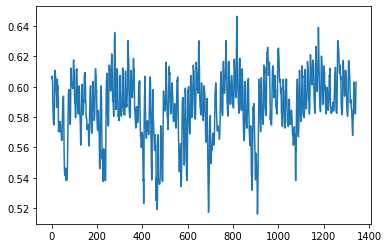

In [0]:
batch = 0 
signal = 0
seq = x_batch[batch , : , signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
MODEL_NAME = 'regression_clipped_extremes_pyramid_28112019_1+24+48'

In [0]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, x_train.shape[1],),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(y_train.shape[1], activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
warmup_steps = 30

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
path_checkpoint = f'/content/gdrive/My Drive/thesis/{MODEL_NAME}.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

callback_tensorboard = TensorBoard(log_dir=f'/content/gdrive/My Drive/thesis/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
model.fit_generator(generator=generator,
                    epochs=60,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping, callback_tensorboard])

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
21/50 [===========>..................] - ETA: 5:58 - loss: 0.0186